In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
from ase.io import read,write
from ase.visualize import view
import numpy as np 

from equistore import Labels, TensorBlock, TensorMap
from itertools import product
from equistore_utils.clebsh_gordan import ClebschGordanReal

import matplotlib.pyplot as plt

# from equistore_utils.librascal import  RascalSphericalExpansion, RascalPairExpansion
# from rascal.representations import SphericalExpansion
from equistore_utils.acdc_mini import acdc_standardize_keys, _remove_suffix
from rascaline import SphericalExpansion
from rascaline import SphericalExpansionByPair as PairExpansion
from equistore import operations
import copy
import ase 
import tqdm 
import hickle

In [3]:
from equistore_utils.mp_utils import *

In [4]:
from ase.io import read

In [9]:
# frames_all = read('bispectrum_counter/carbon/C-VII-pp-wrapped.xyz', ':10000')
# leng = np.asarray([len(f) for f in frames_all])
# frames_14 = []
# for idx in np.where(leng<14)[0]:
# #     print(idx)
#     frames_14.append(frames_all[idx])
# frames = frames_14
# write('bispectrum_counter/carbon/C_lessthan14.xyz', frames)
# print(np.max([np.max(f.get_all_distances()) for f in frames_14]))
frames = read('/home/nigam/scratch/MAC/bispectrum_counter/carbon/C_lessthan14.xyz', ':1000')
print(len(frames))
# frames = read('bisp/C_lessthan14.xyz', ':10')

1000


## Set up basic features

In [6]:
from rascaline import SphericalExpansion
from rascaline import SphericalExpansionByPair as PairExpansion

In [7]:
hypers = {
    "cutoff": 3,
    "max_radial": 4,
    "max_angular": 3,
    "atomic_gaussian_width": 0.2,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    "center_atom_weight": 0.0,    
}

hypers_ij = {
    "cutoff": 2.2,
    "max_radial": 4,
    "max_angular": 3,
    "atomic_gaussian_width": 0.2,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    "center_atom_weight": 0.0,    
}

cg = ClebschGordanReal(5)


In [13]:
calculator = SphericalExpansion(**hypers)
rhoi = calculator.compute(frames[:])
rhoi = rhoi.keys_to_properties(['species_neighbor'])
rho1i = acdc_standardize_keys(rhoi)
# rho1i = operations.slice(rho1i, samples=Labels(['center'],np.array([[0]], np.int32)) )
# norm_rho1 = np.sqrt(np.sum([(b.values**2).sum(axis=(1,2)) for b in rho1i.blocks()],axis=0).mean())
# for b in rho1i.blocks():
#     b.values[:]/=norm_rho1
    

In [9]:
rho2i = cg_combine(rho1i, rho1i, clebsch_gordan=cg, other_keys_match=['species_center'], lcut=3)

In [10]:
rho3i =  cg_combine(rho2i, rho1i, clebsch_gordan=cg, other_keys_match=['species_center'], lcut=0)

In [10]:
calculator = PairExpansion(**hypers_ij)
gij = calculator.compute(frames[:])
# gij = operations.slice(gij, samples=Labels(['first_atom'],np.array([[0]], np.int32)) )
gij =  acdc_standardize_keys(gij)
# for b in gij.blocks():
# #     b.values[:]/=norm_rho1
# # gij = simplify_gij(gij)

In [12]:
# test = operations.sum_over_samples(gij, samples_names=["neighbor"])#, "pair_id"]) 
# np.linalg.norm(rho1i.block(0).values/test.block(0).values -1)

## Compute three-feats

In [11]:
rhoii1i2_nu0 = cg_combine(gij, gij, clebsch_gordan=cg, other_keys_match=['species_center'], lcut=3)

In [14]:
rhoii1i2_nu1 =  cg_combine(rho1i, rhoii1i2_nu0, clebsch_gordan=cg, other_keys_match = ['species_center'], lcut=0)

In [15]:
from sklearn.decomposition import PCA

raw = np.hstack([rhoii1i2_nu1.block(0).values.squeeze(),rhoii1i2_nu1.block(1).values.squeeze()])
print(raw.shape)
feats_n2nu1 = PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw)
# hickle.dump (raw, feat_file+ 'feat_3cnu1.hickle')
# hickle.dump(feats_n2nu1, feat_file+'feat_3cnu1_PCA.hickle')

(203824, 2176)


## Set up energy model 

In [192]:
import torch 
device='cpu'
torch.set_default_dtype(torch.float64)

energy_tot = torch.tensor([f.info["energy"] for f in frames], device=device)
ebase = frames[0].info['energy']/len(frames[0])
y = []
for f in frames:
    y.append(f.info['energy'] - ebase*len(f))
    f.info['energy_rel'] = y[-1]

energy = torch.tensor([f.info["energy_rel"] for f in frames], device=device)
print(torch.min(energy), torch.max(energy))

tensor(-9.3295) tensor(22.9408)


In [193]:
#energy_tot-
np.asarray([energy[i]+ebase*len(f) for i,f in enumerate(frames)])

array([-1536.86916 , -1530.39853 , -1540.1702  , -1537.57818 ,
        -921.637719, -1232.31973 , -1225.63819 , -1849.48077 ,
        -918.945312,  -917.576081, -1844.10024 , -1531.76397 ,
        -919.27928 , -1536.65243 ,  -617.639816, -1228.66386 ,
        -610.854417, -1231.53858 , -1531.30615 ,  -614.52865 ,
       -1224.01959 , -1231.24806 , -1225.43819 ,  -617.646799,
       -1225.50265 , -1226.07922 ,  -923.802628, -1231.53448 ,
       -1236.33326 , -1840.51829 , -1532.50557 ,  -923.123139,
       -1838.96987 , -1537.24822 ,  -610.754116, -1839.02544 ,
       -1529.32881 , -1844.73977 ,  -926.443123, -1232.49232 ,
       -1230.85917 ,  -920.612596, -1537.95293 , -1832.24855 ,
        -612.553602, -1533.93242 , -1844.94392 ,  -610.75521 ,
       -1227.4883  , -1235.57836 , -1530.90006 , -1234.64932 ,
        -610.459936,  -920.659764, -1531.54571 , -1522.32475 ,
        -926.597312,  -923.848294,  -617.791009, -1230.80637 ,
       -1535.88616 , -1842.30777 , -1235.31374 ,  -923.

In [153]:
from ase.units import kcal, Hartree
from ase.units import mol
hartree_kcalpmol = 627.503
kcalpmol/Hartree
print(torch.std(energy)*kcalpmol/Hartree)

In [194]:
def StructureMap(samples_structure, device="cpu"):
    unique_structures, unique_structures_idx = np.unique(
        samples_structure, return_index=True
    )   
    new_samples = samples_structure[np.sort(unique_structures_idx)]
    # we need a list keeping track of where each atomic contribution goes
    # (e.g. if structure ids are [3,3,3,1,1,1,6,6,6] that will be stored as
    # the unique structures [3, 1, 6], structure_map will be
    # [0,0,0,1,1,1,2,2,2]
    replace_rule = dict(zip(unique_structures, range(len(unique_structures))))
    structure_map = torch.tensor(
        [replace_rule[i] for i in samples_structure],
        dtype=torch.long,
        device=device,
    )   
    return structure_map, new_samples, replace_rule

In [195]:
#test on index add 
# x  = np.empty_like(feats_n2nu1[get_triple_sample_idx(ntrain,triple_sample_array):])
# x=torch.from_numpy(x)

# fnat=np.asarray([len(np.where(triple_sample_test[:,0]==i)[0]) for i in range(0,200)])
# i=0
# for ist in range(0,200): 
#     x[i:i+fnat[ist]] = ist
#     i=i+fnat[ist]
    
# sm= Labels(triple_sample_names, triple_sample_test)
# structure_map, new_samples, _ = StructureMap(
#             sm["structure"], "cpu"
#         )
# sum_triples =  torch.zeros(200, x.shape[-1])
# res = sum_triples.index_add_(0, structure_map, x)
# res=res.detach().numpy()
# for i in range(len(fnat)):
#     print(i, int(res[i,0]/fnat[i]))

In [196]:
class TripletEnergy(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.input_size = kwargs["input_size"]
        self.intermediate_size = kwargs["intermediate_size"]
        self.hidden_size = kwargs["hidden_size"]
        self.input_layer = torch.nn.Linear(
            in_features=self.input_size, out_features=self.intermediate_size)

        self.hidden_layer = torch.nn.Linear(
                in_features=self.intermediate_size, out_features=self.hidden_size
            )

        self.out_layer = torch.nn.Linear(
                in_features=self.hidden_size, out_features=1
            )

        self.model = torch.nn.Sequential( self.input_layer,
                                        torch.nn.GroupNorm(4,self.intermediate_size),
                                        torch.nn.SiLU(),
                                         self.hidden_layer,
                                         torch.nn.GroupNorm(4,self.hidden_size),
                                         torch.nn.SiLU(),
                                         self.out_layer
            )

        self.sum_triples=None
#         self.samples = kwargs["triple_samples"]
        self.to(device)

    def structure_wise_energy(self, x, samples):

        structure_map, new_samples, _ = StructureMap(
            samples["structure"], "cpu"
        )
#         print(encoded.shape)
        self.sum_triples =  torch.zeros((len(new_samples), x.shape[-1]), device=x.device)
        self.sum_triples.index_add_(0, structure_map, x)

        return self.sum_triples

    def forward(self, x, samples):

        pred = self.model(x)
        pred = self.structure_wise_energy(pred, samples)

        return pred


# frames = read(frames_file, ':3000')
triple_sample_names = rhoii1i2_nu1.sample_names#np.load(feat_file + 'triple_samples_names.npy')
triple_sample_array = rhoii1i2_nu1[0].samples.view(np.int32).copy().reshape(-1, len(triple_sample_names) )#np.load(feat_file + 'triple_samples.npy')

triple_samples = rhoii1i2_nu1[0].samples #Labels(list(triple_sample_names), triple_sample_array)


In [197]:
feats_n2nu1 = torch.tensor(feats_n2nu1, device=device)

triple_enmodel = TripletEnergy(input_size = feats_n2nu1.shape[-1],
                               intermediate_size = 128,
                               hidden_size = 128,)


/tmp/ipykernel_12929/3187285078.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feats_n2nu1 = torch.tensor(feats_n2nu1, device=device)


In [198]:
def get_triple_sample_idx(i,triple_sample_array):
    #return first instance of structure i
    try:
        return np.where(triple_sample_array[:,0]==i)[0][0]
    except: 
        return None
    
def iterate_minibatches(inputs, outputs, batch_size, triple_sample_array):
    nstruct = triple_sample_array[-1][0]
#     print("number of structures found ", nstruct)
    for index in range(0, nstruct , batch_size):
        start = get_triple_sample_idx(index,triple_sample_array)
        stop = get_triple_sample_idx(index+batch_size,triple_sample_array)
#         print(index, start, stop)
        yield inputs[start : stop], outputs[index : index + batch_size], index
        


In [199]:
def mse_loss(pred, target):
    return torch.sum((pred.flatten() - target.flatten()) ** 2)
best = 1e10
energy_optimizer = torch.optim.Adam(
        triple_enmodel.parameters(),
        lr=1e-3,
        #line_search_fn="strong_wolfe",
        #history_size=128
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(energy_optimizer, factor = 0.8, patience = 200)
ntrain=800

In [200]:
triple_sample_train = triple_sample_array[:get_triple_sample_idx(ntrain,triple_sample_array)].copy()
triple_sample_test = triple_sample_array[get_triple_sample_idx(ntrain,triple_sample_array):].copy()
triple_sample_test[:,0]-= ntrain

In [201]:
triple_sample_train

Labels([[  0,   0, -11, -11],
        [  0,   0, -11,   2],
        [  0,   0, -11,  14],
        ...,
        [799,   9, 228,  78],
        [799,   9, 228, 192],
        [799,   9, 228, 228]], dtype=int32)

In [202]:
ntrain=800
BATCH_SIZE = 50
n_epochs = 5000

for epoch in range(0,  n_epochs):
    all_predictions = []
    triple_enmodel.train(True)
    for feat, target, index in iterate_minibatches(feats_n2nu1[:get_triple_sample_idx(ntrain,triple_sample_array)], energy[:ntrain], BATCH_SIZE,triple_sample_train):
        start = get_triple_sample_idx(index,triple_sample_train)
        stop = get_triple_sample_idx(index+BATCH_SIZE,triple_sample_train)
#         print(start,stop)
        samples= Labels(triple_sample_names, triple_sample_train[start:stop])
#         print(samples)
        predicted = triple_enmodel.forward(feat, samples)
#         print("here")
#         print(index,samples)
        all_predictions.append(predicted.data.detach().numpy())
        l = mse_loss(predicted, target)
        l.backward()
        energy_optimizer.step()
        energy_optimizer.zero_grad()

    all_predictions = np.concatenate(all_predictions, axis = 0)
#     print(all_predictions.shape)
    train_error = mse_loss(torch.tensor(all_predictions), energy[:ntrain])
    scheduler.step(train_error)
    
    triple_enmodel.train(False)
    test_all_predictions = []
    for feat, target,index in iterate_minibatches(feats_n2nu1[get_triple_sample_idx(ntrain,triple_sample_array):], energy[ntrain:], BATCH_SIZE,triple_sample_test):
        start = get_triple_sample_idx(index,triple_sample_test)
        stop = get_triple_sample_idx(index+BATCH_SIZE,triple_sample_test)
#         print(start,stop)
        tsamples= Labels(triple_sample_names, triple_sample_test[start:stop])
#         print(tsamples)
        predicted = triple_enmodel.forward(feat, tsamples)
#         print("here")
        test_all_predictions.append(predicted.data.detach().numpy())

    test_all_predictions = np.concatenate(test_all_predictions, axis = 0)
#     print(test_all_predictions.shape)
    val_error = mse_loss(torch.tensor(test_all_predictions), energy[ntrain:])

    print("epoch: ", epoch, "RMSE train: ", np.sqrt(train_error.detach().numpy()/(ntrain)),
          "RMSE test: ", np.sqrt(val_error.detach().numpy()/((len(frames)-ntrain))))
    if val_error< best:
        best = val_error
        pred_best = all_predictions
        test_best = test_all_predictions
        torch.save({
            'epoch':epoch,
            'model_state_dict': triple_enmodel.state_dict(),
            'optimizer_state_dict': energy_optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss':train_error,
            'valerror':val_error
        }, './bispectrum_counter/carbon/models/batchmc2_triple_p0-nl-best_rel.pt')

epoch:  0 RMSE train:  54.6055516229133 RMSE test:  7.1759014617612875
epoch:  1 RMSE train:  14.60405776681451 RMSE test:  3.9644337450981597
epoch:  2 RMSE train:  6.320263999273893 RMSE test:  3.87724884885509
epoch:  3 RMSE train:  4.13447974660693 RMSE test:  3.631954738280755
epoch:  4 RMSE train:  3.7028220077511276 RMSE test:  3.478465896622179
epoch:  5 RMSE train:  3.5964022216950924 RMSE test:  3.3851991768201666
epoch:  6 RMSE train:  3.4759340105276997 RMSE test:  3.2863000060563285
epoch:  7 RMSE train:  3.334625359928012 RMSE test:  3.1009845891701584
epoch:  8 RMSE train:  3.2177750747506293 RMSE test:  2.96595308902793
epoch:  9 RMSE train:  3.1196766018246143 RMSE test:  2.85136599283969
epoch:  10 RMSE train:  3.0236825202715454 RMSE test:  2.7369792969424416
epoch:  11 RMSE train:  2.9363236794283707 RMSE test:  2.638108338854744
epoch:  12 RMSE train:  2.853936587461554 RMSE test:  2.546090626894465
epoch:  13 RMSE train:  2.7766681630024364 RMSE test:  2.463035148

epoch:  112 RMSE train:  1.278029685484336 RMSE test:  1.9306601867151882
epoch:  113 RMSE train:  1.4192425062991274 RMSE test:  2.1678824940793477
epoch:  114 RMSE train:  1.5710694405307366 RMSE test:  2.435743005384842
epoch:  115 RMSE train:  1.6996998524923286 RMSE test:  2.6655801511931356
epoch:  116 RMSE train:  1.7458430140488146 RMSE test:  2.720126015656362
epoch:  117 RMSE train:  1.6613422114388248 RMSE test:  2.4424505854339986
epoch:  118 RMSE train:  1.5440050329885537 RMSE test:  1.7799191062922703
epoch:  119 RMSE train:  1.8070379501806375 RMSE test:  1.0405599150971945
epoch:  120 RMSE train:  2.788418744120824 RMSE test:  2.382611258169749
epoch:  121 RMSE train:  4.2369860469714515 RMSE test:  5.510657823148552
epoch:  122 RMSE train:  4.343860918723801 RMSE test:  2.923744693424922
epoch:  123 RMSE train:  2.1568680916799083 RMSE test:  1.7735179280677775
epoch:  124 RMSE train:  1.110625698166311 RMSE test:  1.1194396817682268
epoch:  125 RMSE train:  0.8737228

epoch:  223 RMSE train:  0.6136782280284863 RMSE test:  1.0413288622574624
epoch:  224 RMSE train:  0.6124393599411202 RMSE test:  1.04682826008014
epoch:  225 RMSE train:  0.6125774914307345 RMSE test:  1.0536287978518413
epoch:  226 RMSE train:  0.6144937533891393 RMSE test:  1.06197266482997
epoch:  227 RMSE train:  0.618745706103283 RMSE test:  1.0720901860340073
epoch:  228 RMSE train:  0.6260637195228772 RMSE test:  1.0841418323322476
epoch:  229 RMSE train:  0.6373255649204341 RMSE test:  1.098142415929947
epoch:  230 RMSE train:  0.6534528061333539 RMSE test:  1.1138972236543319
epoch:  231 RMSE train:  0.675210965344884 RMSE test:  1.1310038477465385
epoch:  232 RMSE train:  0.7029631225353568 RMSE test:  1.148970011966335
epoch:  233 RMSE train:  0.7365197344921229 RMSE test:  1.167435797825305
epoch:  234 RMSE train:  0.7752426761902261 RMSE test:  1.1863910252384244
epoch:  235 RMSE train:  0.8184091950319907 RMSE test:  1.2062480602889327
epoch:  236 RMSE train:  0.8656240

epoch:  333 RMSE train:  1.258142362605694 RMSE test:  1.6276003500547371
epoch:  334 RMSE train:  1.4029837693986906 RMSE test:  1.776839145291487
epoch:  335 RMSE train:  1.601615669384448 RMSE test:  2.0153509099650444
epoch:  336 RMSE train:  1.887747912846053 RMSE test:  2.43253810732762
epoch:  337 RMSE train:  2.3123428901378382 RMSE test:  3.208426730938511
epoch:  338 RMSE train:  2.887784574367466 RMSE test:  4.413278308819349
epoch:  339 RMSE train:  3.2325858599683137 RMSE test:  4.16600578107866
epoch:  340 RMSE train:  2.6434509483833946 RMSE test:  1.2233499289315428
epoch:  341 RMSE train:  3.3704153313039447 RMSE test:  3.210616649475767
epoch:  342 RMSE train:  1.8805882484552439 RMSE test:  0.930415175206952
epoch:  343 RMSE train:  0.9023563450497494 RMSE test:  1.0512596139863108
epoch:  344 RMSE train:  1.3659069265235209 RMSE test:  1.280113923119124
epoch:  345 RMSE train:  1.0768836377930584 RMSE test:  1.0253681705801654
epoch:  346 RMSE train:  0.923487567178

epoch:  443 RMSE train:  0.6091186193106696 RMSE test:  0.9547366245808389
epoch:  444 RMSE train:  0.6229327371569602 RMSE test:  0.9566040493692131
epoch:  445 RMSE train:  0.6376251288409063 RMSE test:  0.9589593608981332
epoch:  446 RMSE train:  0.6533088624656348 RMSE test:  0.9618345004269112
epoch:  447 RMSE train:  0.6701273186381976 RMSE test:  0.9652692702190757
epoch:  448 RMSE train:  0.6882609954700537 RMSE test:  0.9693137781479321
epoch:  449 RMSE train:  0.707937091783775 RMSE test:  0.9740318754693273
epoch:  450 RMSE train:  0.7294430859784437 RMSE test:  0.9795061060445759
epoch:  451 RMSE train:  0.7531462106713686 RMSE test:  0.9858450206807801
epoch:  452 RMSE train:  0.7795218750496478 RMSE test:  0.993194312660384
epoch:  453 RMSE train:  0.8091961003467074 RMSE test:  1.0017543608900652
epoch:  454 RMSE train:  0.8430106859561626 RMSE test:  1.0118089987912153
epoch:  455 RMSE train:  0.8821267527749755 RMSE test:  1.0237749996897034
epoch:  456 RMSE train:  0.

epoch:  553 RMSE train:  0.42852519586267807 RMSE test:  1.285572909572473
epoch:  554 RMSE train:  0.4240141221113636 RMSE test:  1.2821675194789324
epoch:  555 RMSE train:  0.41958425186208115 RMSE test:  1.2787637650153865
epoch:  556 RMSE train:  0.4152362113234187 RMSE test:  1.275359480571263
epoch:  557 RMSE train:  0.41097072342977226 RMSE test:  1.2719519764208078
epoch:  558 RMSE train:  0.40678865336637815 RMSE test:  1.2685379466448319
epoch:  559 RMSE train:  0.4026910655314554 RMSE test:  1.2651133491966313
epoch:  560 RMSE train:  0.398679296372742 RMSE test:  1.2616732504500423
epoch:  561 RMSE train:  0.394755049344178 RMSE test:  1.2582116244811785
epoch:  562 RMSE train:  0.3909205208234227 RMSE test:  1.2547210949999603
epoch:  563 RMSE train:  0.38717856955268243 RMSE test:  1.2511926055846072
epoch:  564 RMSE train:  0.3835329474648618 RMSE test:  1.247615002415228
epoch:  565 RMSE train:  0.37998861722052774 RMSE test:  1.2439745144856111
epoch:  566 RMSE train: 

epoch:  663 RMSE train:  0.2566807753860684 RMSE test:  0.9790712178905875
epoch:  664 RMSE train:  0.25403151999378104 RMSE test:  0.9795092813095936
epoch:  665 RMSE train:  0.2514807310967943 RMSE test:  0.9799321879453731
epoch:  666 RMSE train:  0.24902181026848322 RMSE test:  0.9803410498010534
epoch:  667 RMSE train:  0.2466487226804419 RMSE test:  0.9807368758361316
epoch:  668 RMSE train:  0.24435594113331288 RMSE test:  0.9811205734167061
epoch:  669 RMSE train:  0.24213839617596267 RMSE test:  0.9814929502374317
epoch:  670 RMSE train:  0.23999143165720394 RMSE test:  0.9818547164992444
epoch:  671 RMSE train:  0.2379107651128551 RMSE test:  0.9822064871761675
epoch:  672 RMSE train:  0.2358924524519193 RMSE test:  0.9825487842410451
epoch:  673 RMSE train:  0.23393285646606055 RMSE test:  0.9828820387462688
epoch:  674 RMSE train:  0.23202861874373937 RMSE test:  0.9832065926739477
epoch:  675 RMSE train:  0.23017663462295665 RMSE test:  0.983522700482636
epoch:  676 RMSE t

KeyboardInterrupt: 

In [203]:
energy.detach().numpy()[:ntrain]

array([ 0.0000000e+00,  6.4706300e+00, -3.3010400e+00, -7.0902000e-01,
        4.8377700e-01, -2.8244020e+00,  3.8571380e+00, -5.2377780e+00,
        3.1761840e+00,  4.5454150e+00,  1.4275200e-01,  5.1051900e+00,
        2.8422160e+00,  2.1673000e-01, -2.8921520e+00,  8.3146800e-01,
        3.8932470e+00, -2.0432520e+00,  5.5630100e+00,  2.1901400e-01,
        5.4757380e+00, -1.7527320e+00,  4.0571380e+00, -2.8991350e+00,
        3.9926780e+00,  3.4161080e+00, -1.6811320e+00, -2.0391520e+00,
       -6.8379320e+00,  3.7247020e+00,  4.3635900e+00, -1.0016430e+00,
        5.2731220e+00, -3.7906000e-01,  3.9935480e+00,  5.2175520e+00,
        7.5403500e+00, -4.9677800e-01, -4.3216270e+00, -2.9969920e+00,
       -1.3638420e+00,  1.5089000e+00, -1.0837700e+00,  1.1994442e+01,
        2.1940620e+00,  2.9367400e+00, -7.0092800e-01,  3.9924540e+00,
        2.0070280e+00, -6.0830320e+00,  5.9691000e+00, -5.1539920e+00,
        4.2877280e+00,  1.4617320e+00,  5.3234500e+00,  1.4544410e+01,
      

In [204]:
energy.detach().numpy()[:ntrain]-pred_best[:,0]

array([ 2.03600384e+00,  2.32148252e+00,  2.73651135e+00,  2.96032223e+00,
        9.30553796e-01,  2.60736763e+00,  3.08036536e+00,  1.74727338e+00,
        3.41618835e+00,  1.86597109e+00,  1.25828928e+00,  3.22994206e+00,
        2.30738441e+00,  3.49885601e+00,  5.76375321e-01,  5.05543199e-01,
        1.65770979e+00,  1.72508876e+00,  2.42603607e+00,  5.17764202e-01,
        2.61315768e+00,  1.55654716e+00,  4.22140410e+00,  7.88827755e-01,
        3.21995355e+00,  2.19804839e+00,  1.01936544e+00,  1.73360359e+00,
        1.81323910e+00,  3.41642776e+00,  4.11787108e+00,  1.01561085e+00,
        3.84705265e+00,  2.56188526e+00,  2.24834970e+00,  4.45594003e+00,
        4.58496009e+00,  3.50950158e+00,  3.94880162e-01,  1.84685266e+00,
        4.01807448e+00,  1.24662130e+00,  3.58087859e+00,  4.59967617e+00,
        1.35149383e+00,  3.70495359e+00,  6.99087837e+00,  1.43031880e+00,
        2.56405120e+00,  1.20147285e+00,  2.51555016e+00, -2.20709716e-01,
        9.59126677e-01,  

In [112]:
pred_best.shape

(800, 1)

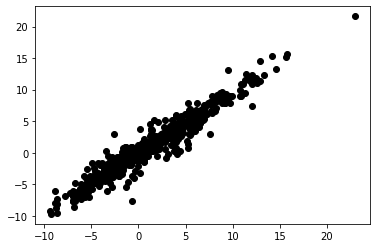

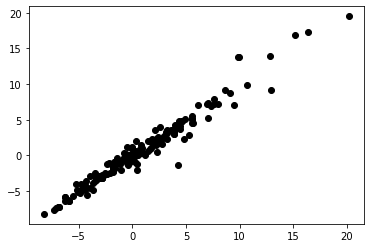

In [205]:
plt.scatter(energy.detach().numpy()[:ntrain], pred_best[:,0], color = 'k', marker='o')
plt.figure()
plt.scatter(energy.detach().numpy()[ntrain:], test_best[:,0], color = 'k', marker='o')

In [216]:
torch.sqrt(mse_loss(energy_tot[ntrain:], torch.tensor([test_best[:,0][i]+ebase*len(f) for i,f in enumerate(frames[ntrain:])]))/200)

tensor(0.9291)

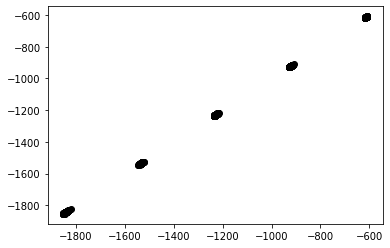

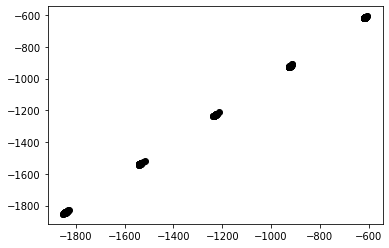

In [209]:
plt.scatter(energy_tot.detach().numpy()[:ntrain], np.asarray([pred_best[:,0][i]+ebase*len(f) for i,f in enumerate(frames[:ntrain])]), color = 'k', marker='o')
plt.figure()
plt.scatter(energy_tot.detach().numpy()[ntrain:], np.asarray([test_best[:,0][i]+ebase*len(f) for i,f in enumerate(frames[ntrain:])]), color = 'k', marker='o')


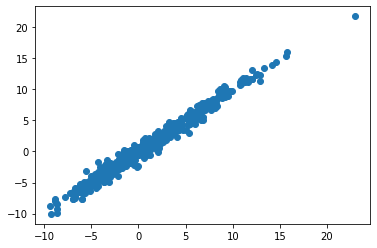

In [72]:
plt.scatter(energy[:ntrain], pred_best)

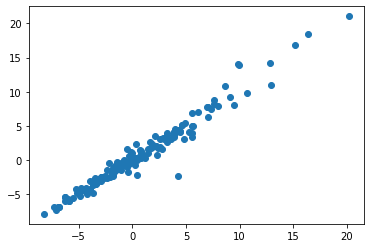

In [73]:
plt.scatter(energy[ntrain:], test_best)

In [ ]:
fnat = np.asarray([len(f) for f in frames])

In [32]:
sum(fnat**3)

72208

In [45]:
triple_sample_array[np.where(triple_sample_array[:,0]==20)[0]]

Labels([[ 20,   0, -11, -11],
        [ 20,   0, -11,   1],
        [ 20,   0, -11,  15],
        [ 20,   0, -11,  27],
        [ 20,   0, -11,  40],
        [ 20,   1, -10, -10],
        [ 20,   1, -10,   0],
        [ 20,   1, -10,  48],
        [ 20,   1, -10,  60],
        [ 20,   1, -10,  72],
        [ 20,   2,  -9,  -9],
        [ 20,   2,  -9,  80],
        [ 20,   2,  -9,  91],
        [ 20,   2,  -9, 106],
        [ 20,   3,  -8,  -8],
        [ 20,   3,  -8,  79],
        [ 20,   3,  -8,  90],
        [ 20,   3,  -8, 116],
        [ 20,   4,  -7,  -7],
        [ 20,   4,  -7,  11],
        [ 20,   4,  -7,  45],
        [ 20,   4,  -7, 126],
        [ 20,   4,  -7, 137],
        [ 20,   5,  -6,  -6],
        [ 20,   5,  -6,  22],
        [ 20,   5,  -6,  56],
        [ 20,   5,  -6, 125],
        [ 20,   5,  -6, 136],
        [ 20,   6,  -5,  -5],
        [ 20,   6,  -5,  67],
        [ 20,   6,  -5, 113],
        [ 20,   6,  -5, 150],
        [ 20,   6,  -5, 161],
        [ 

In [38]:
np.where(triple_sample_array[:,0]==1)[0]

array([214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226,
       227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252,
       253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265,
       266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278,
       279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291,
       292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304,
       305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
       318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330,
       331])